# Step 1: Brief description of the problem and data

In this notebook, I will be training a model to predict whether a given tweet is about a real disaster (1) or not (0).

The training data provided in `train.csv` contains the following columns:
* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - this denotes whether a tweet is about a real disaster (1) or not (0)

Since the size of the data is not mentioned in the Kaggle data description, let's do a quick check to see how many rows of data are in the `train.csv` file.

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Input, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from keras.src.optimizers import Adam
from keras_tuner import Hyperband
import re
import emoji
import string

In [171]:
file_name = "train.csv"
data = pd.read_csv(file_name)
num_rows = data.shape[0]
print(f"The number of rows in '{file_name}' is {num_rows}.")

The number of rows in 'train.csv' is 7613.


# Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

I've broken the EDA up into a few different parts, where I'll look at different aspects of the data.  At the end of step 2, I'll summarize what I've learned from the EDA and discuss next steps.

## Step 2 Part 1: Overview
Let's take a look at some basic statistics of the data like mean, standard deviation, min, and max for numerical columns (e.g., id, target).

In [172]:
print("\nFirst 5 rows of the dataset:")
print(data.head())

print("\nSummary statistics for numerical columns:")
print(data.describe())

print("\nData types of each column:")
print(data.dtypes)

print("\nMissing values in each column:")
print(data.isnull().sum())

print("\nPercentage of missing values in each column:")
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

duplicate_rows = data.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows)

text_duplicates = data['text'].duplicated().sum()
print("\nNumber of duplicate rows based on 'text' column:", text_duplicates)

print("\nNumber of unique values in each column:")
print(data.nunique())


First 5 rows of the dataset:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Summary statistics for numerical columns:
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

Data types of each column:
id           int64
keyword     object
location    object
text        object


## Step 2 Part 2: `Target` Distribution
Is the distribution of the `target` column balanced?  If not, re-balancing may be needed.

Distribution of the target column:
target
0    4342
1    3271
Name: count, dtype: int64

Percentage of each target class:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


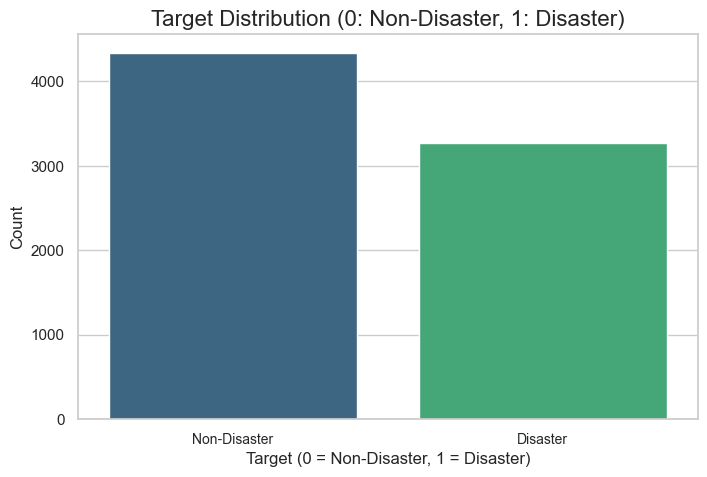

In [173]:
print("Distribution of the target column:")
print(data['target'].value_counts())

print("\nPercentage of each target class:")
target_percentage = (data['target'].value_counts(normalize=True)) * 100
print(target_percentage)

plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='target', hue='target', legend=False, palette='viridis')
plt.title('Target Distribution (0: Non-Disaster, 1: Disaster)', fontsize=16)
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'], fontsize=10)
plt.show()

## Step 2 Part 3: `Text` Analysis
Now let's look at text length, most common words, stopwords and special characters, the prevalence of stopwords (e.g., "the", "is"), and sentiment analysis.

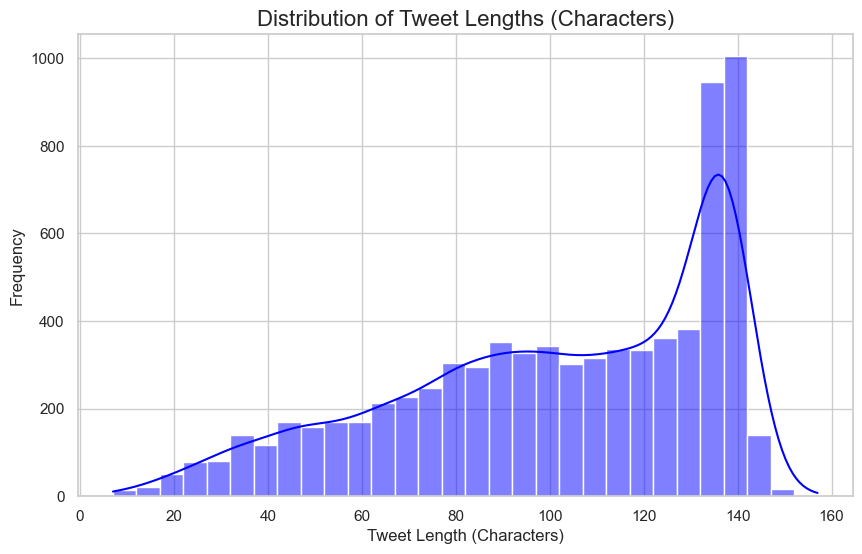

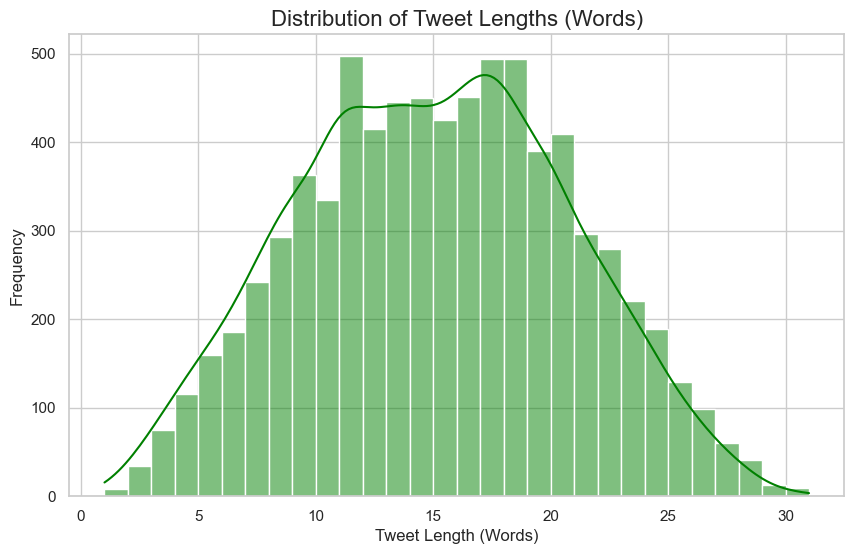

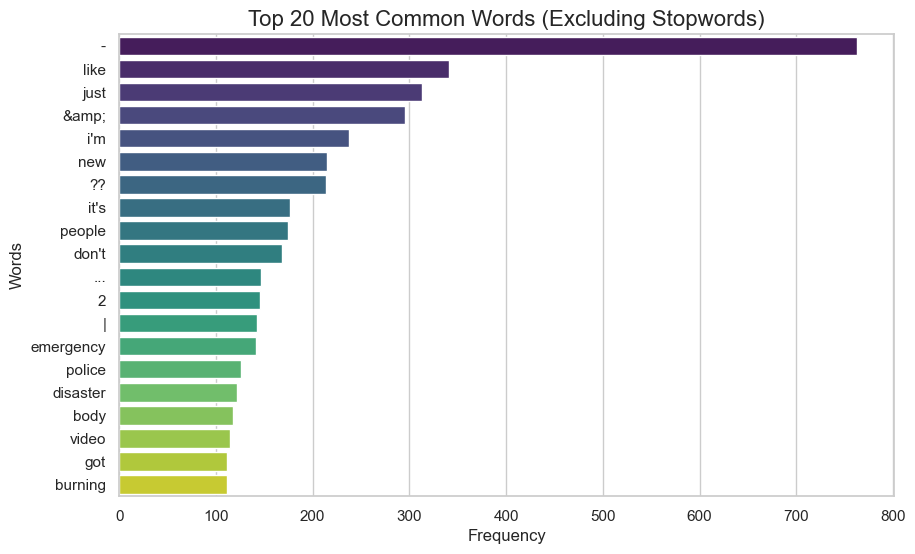

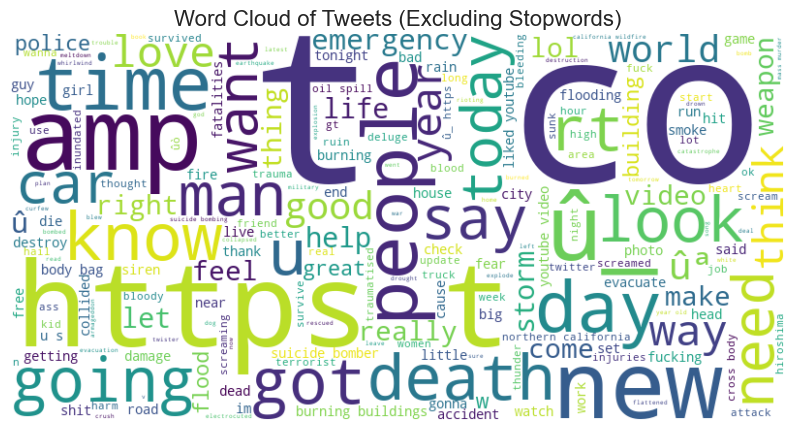

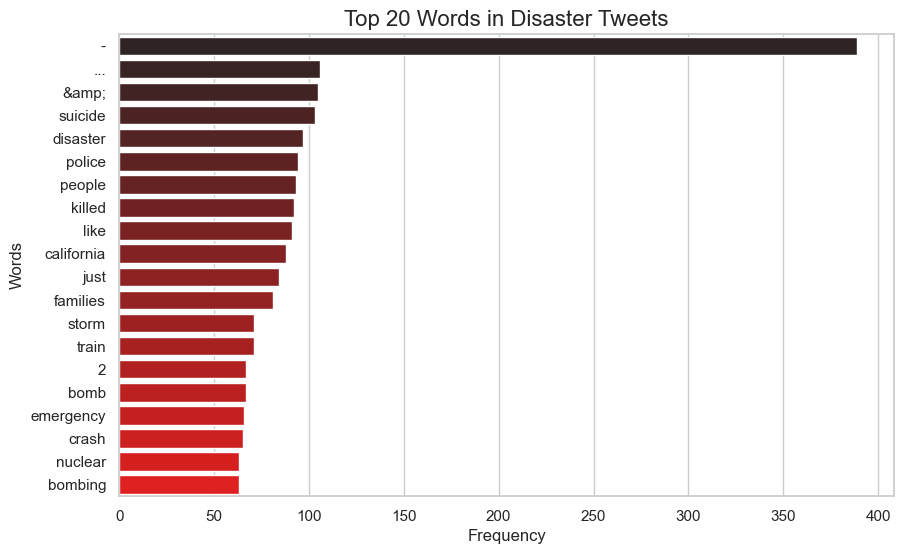

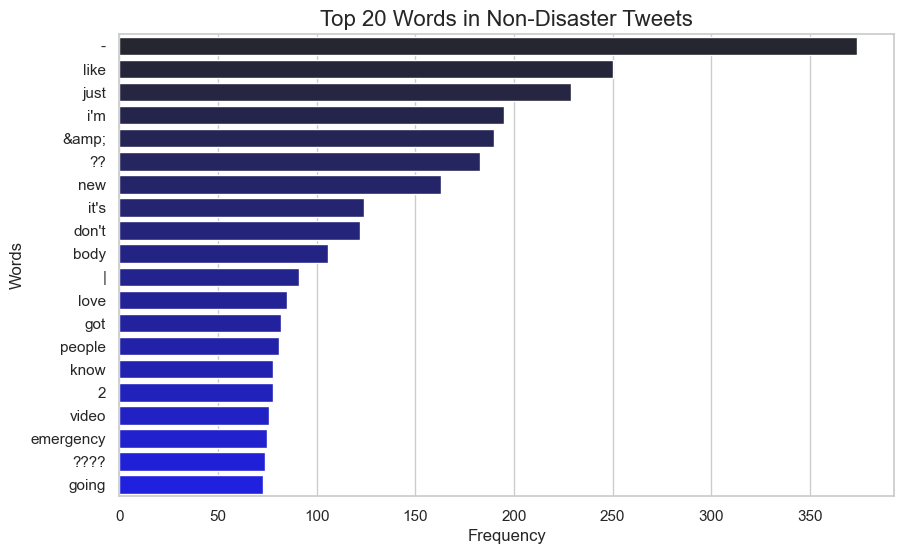

In [174]:
# Calculate tweet lengths (number of characters and words)
data['text_length'] = data['text'].apply(len)
data['word_count'] = data['text'].apply(lambda x: len(x.split()))

# Visualize tweet lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths (Characters)', fontsize=16)
plt.xlabel('Tweet Length (Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['word_count'], bins=30, kde=True, color='green')
plt.title('Distribution of Tweet Lengths (Words)', fontsize=16)
plt.xlabel('Tweet Length (Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Tokenize text and count word frequencies
stop_words = ENGLISH_STOP_WORDS
all_words = [word.lower() for tweet in data['text'] for word in tweet.split() if word.lower() not in stop_words]

word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Visualize most common words
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), hue=list(words), palette='viridis')
plt.title('Top 20 Most Common Words (Excluding Stopwords)', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()

# Word cloud for entire dataset
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets (Excluding Stopwords)', fontsize=16)
plt.show()

# Compare most common words between target classes
disaster_words = [word.lower() for tweet in data[data['target'] == 1]['text'] for word in tweet.split() if word.lower() not in stop_words]
non_disaster_words = [word.lower() for tweet in data[data['target'] == 0]['text'] for word in tweet.split() if word.lower() not in stop_words]

disaster_counts = Counter(disaster_words).most_common(20)
non_disaster_counts = Counter(non_disaster_words).most_common(20)

# Plot disaster vs. non-disaster word frequencies
disaster_words, disaster_freq = zip(*disaster_counts)
non_disaster_words, non_disaster_freq = zip(*non_disaster_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(disaster_freq), y=list(disaster_words), hue=list(disaster_words), palette='dark:red')
plt.title('Top 20 Words in Disaster Tweets', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=list(non_disaster_freq), y=list(non_disaster_words), hue=list(non_disaster_words), palette='dark:blue')
plt.title('Top 20 Words in Non-Disaster Tweets', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()

Continuing with the `text` analysis, lets take a look at hashtags, mentions, and emojis.

In [175]:
# Define helper functions to count hashtags, mentions, and emojis
def count_hashtags(text):
    return len(re.findall(r"#\w+", text))

def count_mentions(text):
    return len(re.findall(r"@\w+", text))

def count_emojis(text):
    return len([char for char in text if char in emoji.EMOJI_DATA])

# Apply the functions to the 'text' column, and create a new column for counts of hashtags, mentions, and emojis
data['hashtag_count'] = data['text'].apply(count_hashtags)
data['mention_count'] = data['text'].apply(count_mentions)
data['emoji_count'] = data['text'].apply(count_emojis)

# Display the counts
print("Hashtag Counts:\n", data['hashtag_count'].value_counts())
print("Mention Counts:\n", data['mention_count'].value_counts())
print("Emoji Counts:\n", data['emoji_count'].value_counts())

Hashtag Counts:
 hashtag_count
0     5870
1      964
2      407
3      202
4       71
5       39
6       27
10      10
8        8
7        7
13       4
11       2
9        2
Name: count, dtype: int64
Mention Counts:
 mention_count
0    5604
1    1531
2     338
3      86
4      30
5      17
6       5
8       1
7       1
Name: count, dtype: int64
Emoji Counts:
 emoji_count
0    7603
1      10
Name: count, dtype: int64


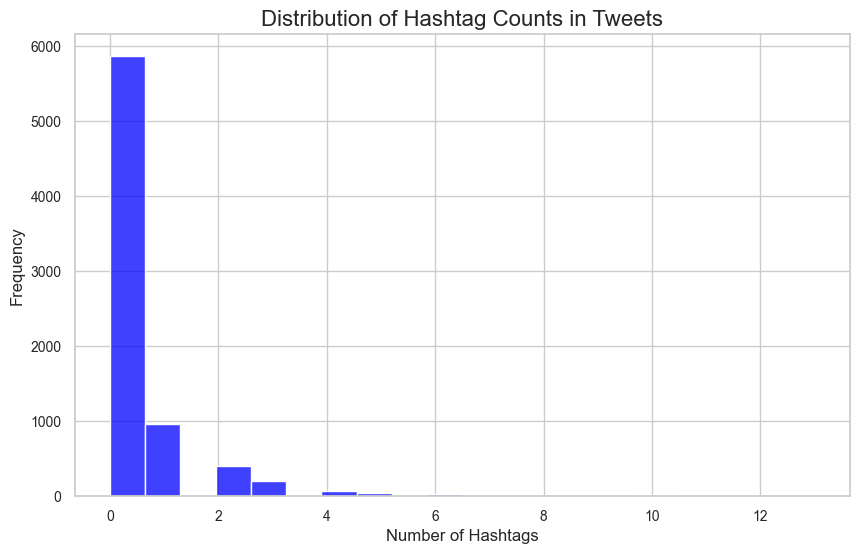

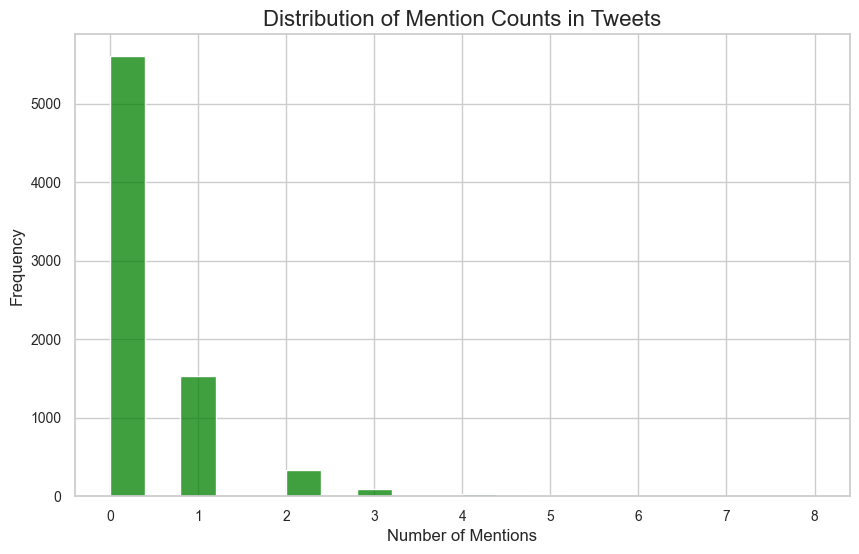

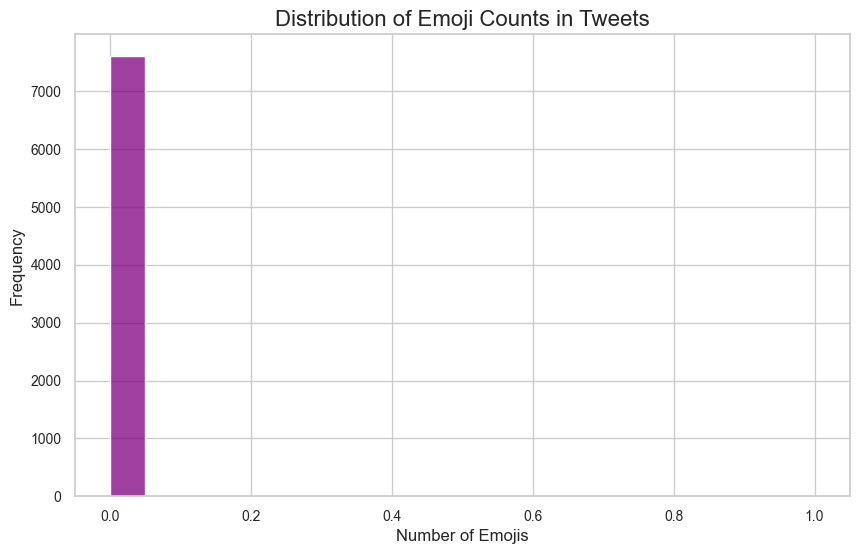

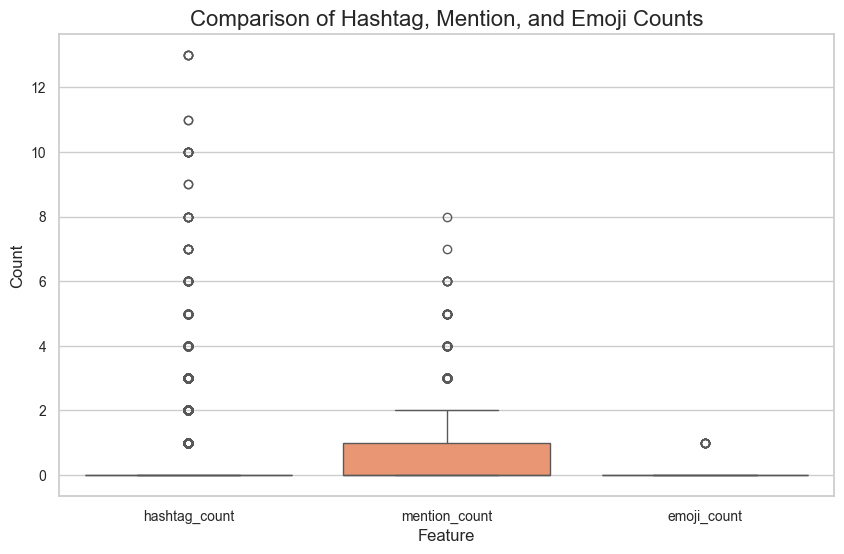

In [176]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data['hashtag_count'], bins=20, kde=False, color='blue')
plt.title('Distribution of Hashtag Counts in Tweets', fontsize=16)
plt.xlabel('Number of Hashtags', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['mention_count'], bins=20, kde=False, color='green')
plt.title('Distribution of Mention Counts in Tweets', fontsize=16)
plt.xlabel('Number of Mentions', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['emoji_count'], bins=20, kde=False, color='purple')
plt.title('Distribution of Emoji Counts in Tweets', fontsize=16)
plt.xlabel('Number of Emojis', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Compare counts across the three categories using box plots
plt.figure(figsize=(10, 6))
df_melted = data.melt(value_vars=['hashtag_count', 'mention_count', 'emoji_count'],
                    var_name='Feature', value_name='Count')
sns.boxplot(x='Feature', y='Count', data=df_melted, hue='Feature', legend=False, palette='Set2')
plt.title('Comparison of Hashtag, Mention, and Emoji Counts', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## Step 2 Part 4: `Keyword` Analysis
Let's look at the most frequently occurring keywords, examine if specific keywords are associated with real disasters (target = 1), and analyze the correlation between keywords and the target class.


Keyword distribution (with NaN):
keyword
NaN            61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
Name: count, dtype: int64

Keyword distribution (excluding NaN):
keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: count, dtype: int64

Percentage of missing keywords: 0.80%


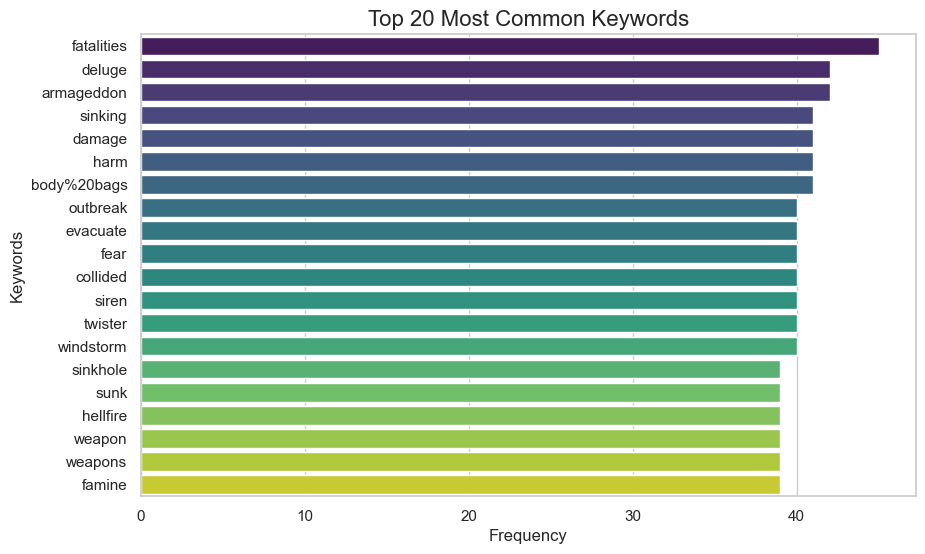

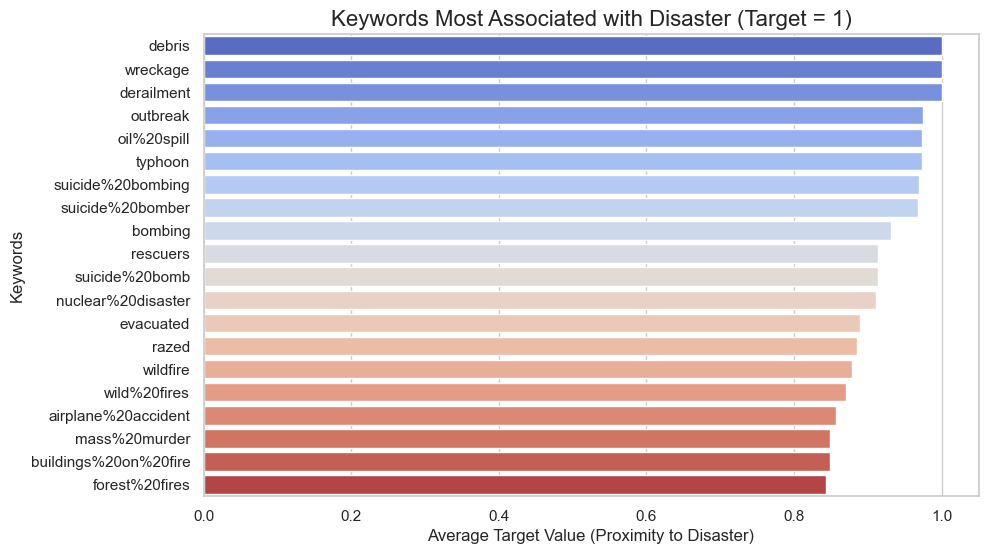

In [177]:
print("Keyword distribution (with NaN):")
print(data['keyword'].value_counts(dropna=False).head(10))

print("\nKeyword distribution (excluding NaN):")
print(data['keyword'].dropna().value_counts().head(10))

missing_keywords = data['keyword'].isnull().sum()
total_rows = len(data)
print(f"\nPercentage of missing keywords: {missing_keywords / total_rows * 100:.2f}%")

# Visualize the most common keywords
top_keywords = data['keyword'].dropna().value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, hue=top_keywords.index, palette="viridis")
plt.title('Top 20 Most Common Keywords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Keywords', fontsize=12)
plt.show()

# Group by keyword and calculate the mean target (higher mean implies more likely to be disaster-related)
keyword_target_relation = data.groupby('keyword')['target'].mean().sort_values(ascending=False).dropna().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=keyword_target_relation.values, y=keyword_target_relation.index, hue=keyword_target_relation.index, palette="coolwarm")
plt.title('Keywords Most Associated with Disaster (Target = 1)', fontsize=16)
plt.xlabel('Average Target Value (Proximity to Disaster)', fontsize=12)
plt.ylabel('Keywords', fontsize=12)
plt.show()

## Step 2 Part 5: Top Locations
Let's take a look at the most common location values, the location-target relationship, and missing locations.

Location distribution (with NaN):
location
NaN                2533
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Name: count, dtype: int64

Location distribution (excluding NaN):
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64

Percentage of missing locations: 33.27%


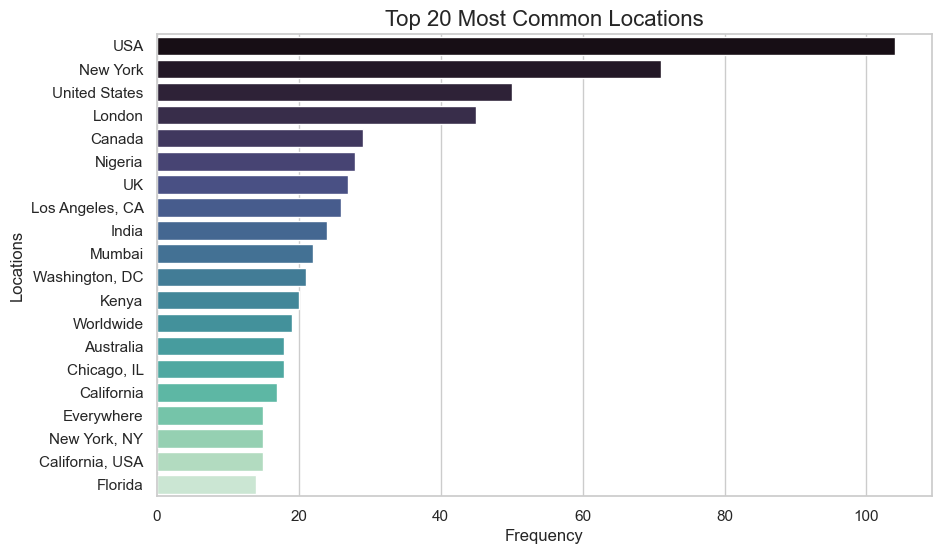

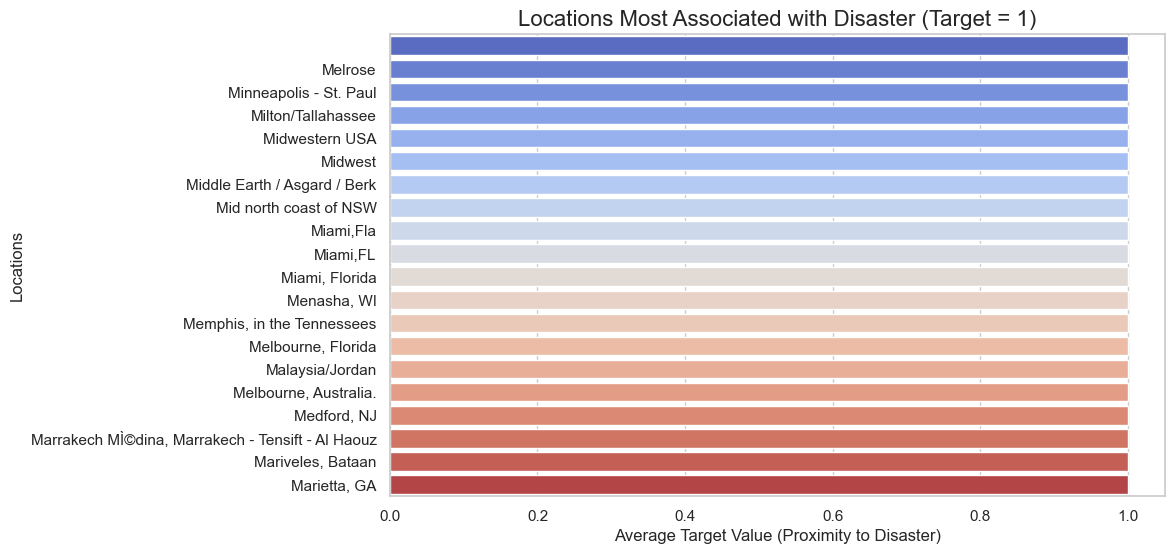

In [178]:
print("Location distribution (with NaN):")
print(data['location'].value_counts(dropna=False).head(10))

print("\nLocation distribution (excluding NaN):")
print(data['location'].dropna().value_counts().head(10))

missing_locations = data['location'].isnull().sum()
total_rows = len(data)
print(f"\nPercentage of missing locations: {missing_locations / total_rows * 100:.2f}%")

# Visualize most common locations
top_locations = data['location'].dropna().value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, hue=top_locations.index, legend=False, palette="mako")
plt.title('Top 20 Most Common Locations', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Locations', fontsize=12)
plt.show()

# Group by location and calculate the mean target (higher mean implies more likely to be disaster-related)
location_target_relation = data.groupby('location')['target'].mean().sort_values(ascending=False).dropna().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=location_target_relation.values, y=location_target_relation.index, hue=location_target_relation.index, legend=False, palette="coolwarm")
plt.title('Locations Most Associated with Disaster (Target = 1)', fontsize=16)
plt.xlabel('Average Target Value (Proximity to Disaster)', fontsize=12)
plt.ylabel('Locations', fontsize=12)
plt.show()

## Step 2 Part 6: Correlations
Next I'll compare tweet lengths, word counts, and vocabulary richness between the two classes.  Then I'll look for keyword-location interaction, such as how often specific keywords appear in tweets from particular locations.


Correlation matrix:
               target  text_length  word_count
target       1.000000     0.181817    0.039966
text_length  0.181817     1.000000    0.837386
word_count   0.039966     0.837386    1.000000


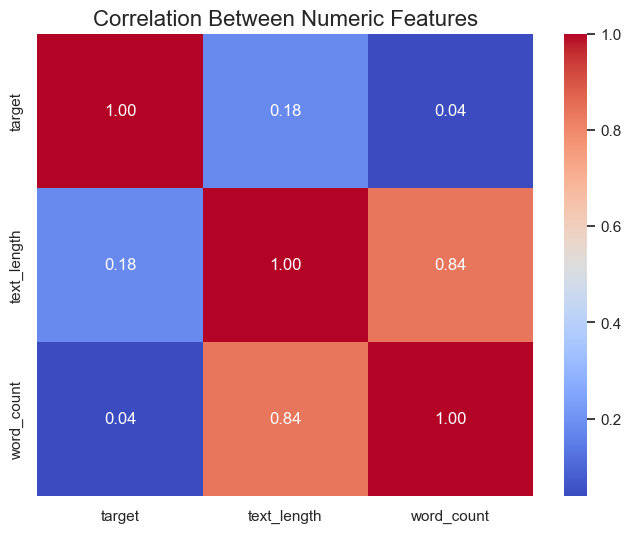

In [179]:
# Select only numeric features for correlation
numeric_features = data[['target', 'text_length', 'word_count']]
correlation_matrix = numeric_features.corr()
print("Correlation matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Between Numeric Features', fontsize=16)
plt.show()

## Step 2 Conclusion
We learned a lot through the EDA above.  Here's a summary.
1. **Overview**: There are 0 duplicate rows, but there are 110 duplicate rows based on the `text` column.  If 2 rows have the same `text` but only one row has `location`, we should keep the row that contains more information and delete the other.  There are some NaN values in the `keyword` and `location` columns that may cause issues in certain tools that we use later (i.e. TF-IDF as a text vectorizer or Tokenizer as a text preprocessing library).
2. **`Target` Distribution**: The training data contains 57% non-disaster (target=0) and 43% disaster.
3. **`Text` Analysis**: Tweets with close to 140 characters were the most common, and the most common number of words in a tweet was 10-20 words.  When comparing the most common words in disaster vs. non-disaster tweets, some words were common in both types such as "like", "&amp", "just", "-", and "2".  Other words were only popular in either disaster or non-disaster tweets.  For example, words such as "i'm", "??", "new", and "it's" were popular in non-disaster tweets, while words such as "suicide", "disaster", "police", and "people" were popular in disaster tweets.  The text contains a significant number of hashtags and mentions, along with a few emojis.
4. **`Keyword` Analysis**: We learned in step 2 part 1 that there are 221 unique keywords, and that a majority of entries in the training data (99.2%) have keywords.  By viewing the top 20 keywords in one visualization and the keywords most associated with disaster in another visualization, we saw many keywords that were associated with disaster but not among the most popular keywords such as "debris", "wreckage", and "derailment" that may be helpful in identifying disaster tweets.
5. **Top Locations**: We looked at the most common locations and then looked at the locations most commonly associated with disasters.  General / vague locations such as "USA" and "United States" were common, while specific locations such as "Melrose" and "Minneapolis - St. Paul" were commonly associated with disasters.
6. **Correlations**: Both the text length and the word count were poorly correlated with the target.

Based on this EDA, the following data cleanup will be performed:
* Clean up the 110 duplicate rows based on the `text` column by deleting the row with less information.  For example, if 2 rows have the same `text` but only one row has `location`, should keep the row that contains more information and delete the other.
* Fill in `NaN` values in the `keyword` and `location` fields with "Unknown".  I chose "Unknown" rather than leaving the `NaN` value or replacing with a blank value "" so that this information can be used to signal "missingness" to the model explicitly.  Another alternative would be to delete all training entries with `NaN` values, but that would cause us to lose a lot of useful training data, which is undesirable.
* Remove all stop words, hashtags, mentions, and emojis.

In [180]:
def replace_nan_values_with_unknown(data):
    data['keyword'] = data['keyword'].fillna("Unknown")
    data['location'] = data['location'].fillna("Unknown")

def remove_duplicates(data):
    # Remove duplicates that contain the least information (i.e. if the same text appears twice and one instance contains a location, keep the entry with the location)
    def info_score(row):
        score = 0
        if pd.notnull(row['location']) and row['location'].strip() != '':
            score += 1
        if pd.notnull(row['keyword']) and row['keyword'].strip() != '':
            score += 1
        return score

    # Add a new column 'info_score' to rank rows based on the amount of information
    data['info_score'] = data.apply(info_score, axis=1)
    data = data.sort_values(by=['text', 'info_score'], ascending=[True, False])

    # Remove duplicates based on 'text', keeping the row with the highest 'info_score'
    data = data.drop_duplicates(subset='text', keep='first')
    data = data.drop(columns=['info_score'])

def remove_urls_mentions_hashtags_emojis(data):
    def clean_text(text):
        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
        # Remove mentions (e.g., @username)
        text = re.sub(r"@\w+", "", text)
        # Remove hashtags (but keep the text after #, e.g., #disaster -> disaster)
        text = re.sub(r"#", "", text)
        # Remove emojis
        text = emoji.replace_emoji(text, replace="")
        # Remove extra whitespaces
        text = re.sub(r"\s+", " ", text).strip()
        return text

    # Apply the cleaning function to the 'text' column
    data['text'] = data['text'].apply(clean_text)

def lowercase_text_and_remove_punctuation(data):
    def lowercase_text_and_remove_punctuation_helper(text):
        text = text.lower()
        text = text.translate(str.maketrans("", "", string.punctuation))
        return text

    data['text'] = data['text'].apply(lowercase_text_and_remove_punctuation_helper)

def remove_stop_words(data):
    data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in ENGLISH_STOP_WORDS]))

# Step 3: Model Architecture
I plan to create 4 separate models:
1. Baseline model
2. Baseline model with tuned hyperparameters
3. BiLSTM model
4. BiLSTM model with tuned hyperparameters

## Baseline model: Fully connected feed forward network using dense layers and TF-IDF
There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc.  For my first model, I'm going to start with a simple TF-IDF model.  We covered TF-IDF in a previous course in this machine learning specialization, but here's a refresher on it.  TF-IDF (term frequency-inverse document frequency) is a statistical measure to evaluate the importance of a word in a document (TF) relative to the collection of documents (IDF).  So if a word is common across all of the documents, then its appearance in a single document is less important.  But if the word is uncommon across all documents, it has high importance when encountered in a single document.

This baseline model does not consider the order of the text, but it is computationally efficient.  This allows me to rapidly iterate on this model as a baseline before progressing to a more complex model that utilizes or bi-directional long short-term memory (aka. BiLSTM).

In [184]:
def open_file_and_clean_data(input_file):
    df = pd.read_csv(input_file)

    replace_nan_values_with_unknown(df)
    remove_duplicates(df)
    remove_urls_mentions_hashtags_emojis(df)
    lowercase_text_and_remove_punctuation(df)
    remove_stop_words(df)

    return df

In [185]:
data = open_file_and_clean_data("train.csv")

X = data['text']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf = TfidfVectorizer(max_features=5000)

def text_to_tfidf(x_train, x_test):
    x_train_tfidf = tfidf.fit_transform(x_train).toarray()
    x_test_tfidf = tfidf.transform(x_test).toarray()
    return x_train_tfidf, x_test_tfidf

X_train_rep, X_test_rep = text_to_tfidf(X_train, X_test)
embedding_matrix = None
vocab_size = None
max_length = None
embedding_dim = None

model = Sequential()

# Add dense layers for TF-IDF representation
model.add(Input(shape=(X_train_rep.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train_rep, y_train,
          epochs=20,
          batch_size=64,
          validation_data=(X_test_rep, y_test),
          callbacks=[lr_scheduler, early_stopping])

loss, accuracy = model.evaluate(X_test_rep, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5824 - loss: 0.6707 - val_accuracy: 0.8030 - val_loss: 0.4671 - learning_rate: 0.0010
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.4025 - val_accuracy: 0.8076 - val_loss: 0.4408 - learning_rate: 0.0010
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8804 - loss: 0.3001 - val_accuracy: 0.7991 - val_loss: 0.4928 - learning_rate: 0.0010
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9205 - loss: 0.2154 - val_accuracy: 0.7965 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9378 - loss: 0.1696 - val_accuracy: 0.7899 - val_loss: 0.5962 - learning_rate: 0.0010
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9534 - loss: 0.1354 - val_accuracy: 0.7853 - val_loss: 0.6447 - learning_rate: 5.0000e-04
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9631 - loss: 0.1113 - val_accura

In [186]:
def test_model_with_tfidf(model, output_file_name='submission.csv'):
    test_df = open_file_and_clean_data("test.csv")

    X_test_final = tfidf.transform(test_df['text']).toarray()
    predictions = model.predict(X_test_final)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    submission = pd.DataFrame({'id': test_df['id'], 'target': predicted_labels})
    submission.to_csv(output_file_name, index=False)

    print("Submission file '", output_file_name, "' has been created.")

test_model_with_tfidf(model)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
Submission file ' submission.csv ' has been created.


# Step 4: Results and Analysis
## Step 4 Part 1: Baseline model with hyperparameter tuning
Now I'll improve on the baseline model using hyperparameter tuning.  The following hyperparameters will be tuned:
1. Number of units in the dense layers
2. Dropout rate
3. Learning rate

I will use early stopping when performing the search to prevent overfitting.

In [187]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_rep.shape[1],)))
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=32),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.7, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=16),
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperband_tuning',
    project_name='tweet_disaster_classification'
)

# Define early stopping to prevent overfitting during search
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train_rep, y_train, epochs=20, validation_data=(X_test_rep, y_test), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first dense layer is {best_hps.get('units_1')}.
The optimal dropout rate is {best_hps.get('dropout_1')}.
The optimal number of units in the second dense layer is {best_hps.get('units_2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Train the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_model.fit(X_train_rep, y_train,
                         epochs=20,
                         batch_size=64,
                         validation_data=(X_test_rep, y_test),
                         callbacks=[lr_scheduler, early_stopping])

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test_rep, y_test)
print(f"Test Accuracy: {accuracy}")

Reloading Tuner from hyperband_tuning/tweet_disaster_classification/tuner0.json

The optimal number of units in the first dense layer is 128.
The optimal dropout rate is 0.5.
The optimal number of units in the second dense layer is 64.
The optimal learning rate is 0.001.

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5836 - loss: 0.6676 - val_accuracy: 0.8175 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8385 - loss: 0.3959 - val_accuracy: 0.8168 - val_loss: 0.4393 - learning_rate: 0.0010
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8827 - loss: 0.2905 - val_accuracy: 0.7997 - val_loss: 0.4831 - learning_rate: 0.0010
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9146 - loss: 0.2178 - val_accuracy: 0.7932 - val_loss: 0.5380 - learning_rate: 0.0010
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9371 - loss: 0.1651 - val_accuracy: 0.7899 - val_loss: 0.5885 -

In [191]:
test_model_with_tfidf(best_model, "tuned_baseline_submission.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
Submission file ' tuned_baseline_submission.csv ' has been created.


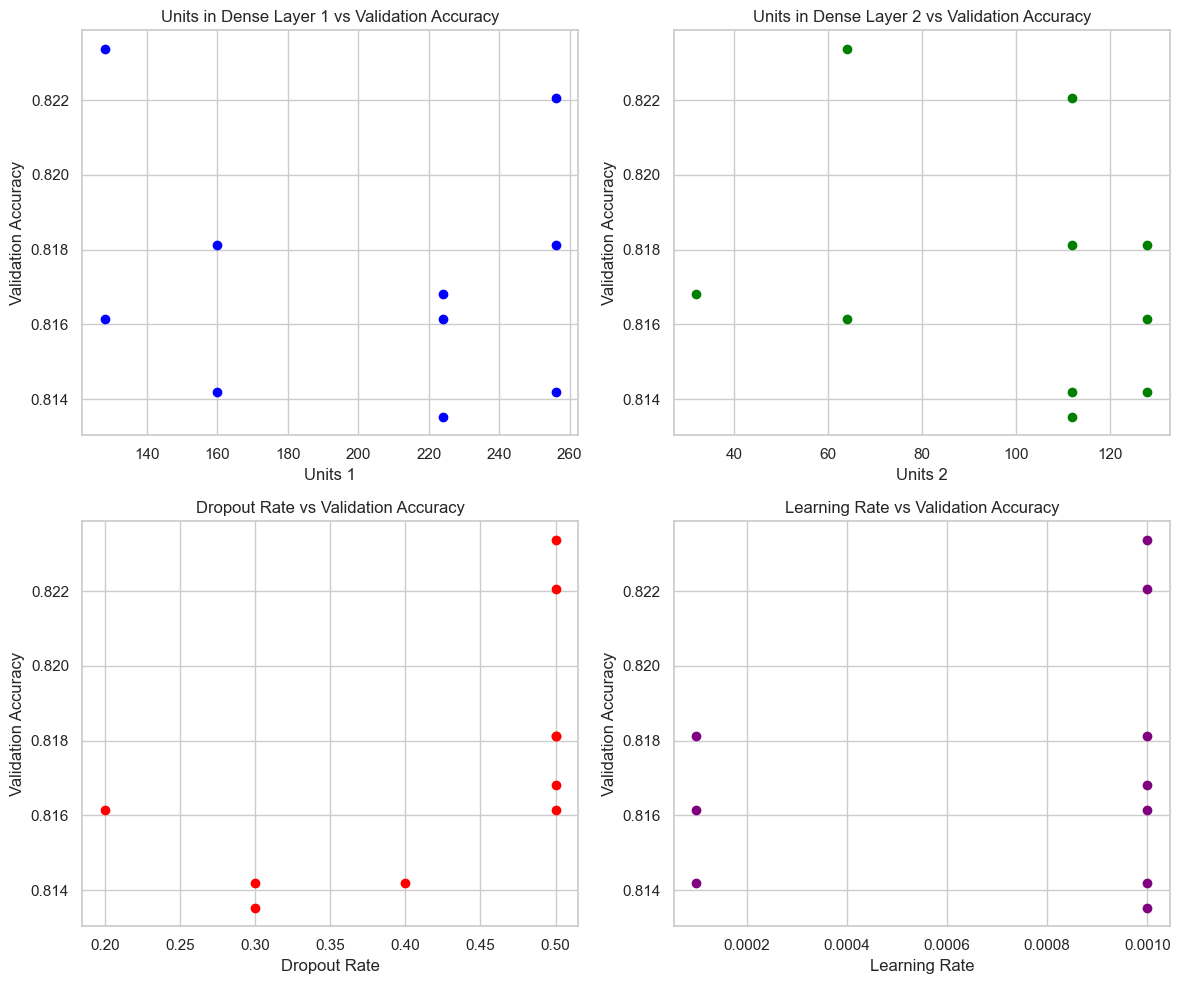

In [190]:
# Plot out the accuracy vs. the 4 hyperparameters that have been tuned to help see
# which hyperparameters have the largest impact on accuracy.
tuner_results = tuner.oracle.get_best_trials(num_trials=10)
units_1_list = []
units_2_list = []
dropout_1_list = []
learning_rate_list = []
val_accuracy_list = []

for trial in tuner_results:
    hp = trial.hyperparameters
    units_1_list.append(hp.get('units_1'))
    units_2_list.append(hp.get('units_2'))
    dropout_1_list.append(hp.get('dropout_1'))
    learning_rate_list.append(hp.get('learning_rate'))
    val_accuracy_list.append(trial.score)

results_df = pd.DataFrame({
    'units_1': units_1_list,
    'units_2': units_2_list,
    'dropout_1': dropout_1_list,
    'learning_rate': learning_rate_list,
    'val_accuracy': val_accuracy_list
})

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].scatter(results_df['units_1'], results_df['val_accuracy'], c='blue')
axs[0, 0].set_title('Units in Dense Layer 1 vs Validation Accuracy')
axs[0, 0].set_xlabel('Units 1')
axs[0, 0].set_ylabel('Validation Accuracy')

axs[0, 1].scatter(results_df['units_2'], results_df['val_accuracy'], c='green')
axs[0, 1].set_title('Units in Dense Layer 2 vs Validation Accuracy')
axs[0, 1].set_xlabel('Units 2')
axs[0, 1].set_ylabel('Validation Accuracy')

axs[1, 0].scatter(results_df['dropout_1'], results_df['val_accuracy'], c='red')
axs[1, 0].set_title('Dropout Rate vs Validation Accuracy')
axs[1, 0].set_xlabel('Dropout Rate')
axs[1, 0].set_ylabel('Validation Accuracy')

axs[1, 1].scatter(results_df['learning_rate'], results_df['val_accuracy'], c='purple')
axs[1, 1].set_title('Learning Rate vs Validation Accuracy')
axs[1, 1].set_xlabel('Learning Rate')
axs[1, 1].set_ylabel('Validation Accuracy')

plt.tight_layout()
plt.show()


After submitting the baseline model with hyperparameter tuning to Kaggle, the accuracy is marginally worse than baseline model without hyperparameter tuning.

## Step 4 Part 2: Model with LSTM (long short-term memory)
Now that the baseline model is understood, I'll develop a model using LSTM (long short-term memory) to capture context from other words in the sequence.  This is more computationally expensive than the baseline model.  By including context from other words in the sequence, this should be a good fit for short and noisy text such as tweets, where understanding subtle word dependencies can be important.

In [192]:
def tokenize_and_pad_sequences(texts, tokenizer=None, max_vocab_size=10000, max_len=100, fit=True):
    if fit:
        tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
        tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    return tokenizer, padded_sequences

data = open_file_and_clean_data("train.csv")

X = data['text']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vocab_size = 10000
embedding_dim = 100
max_len = 100

tokenizer, X_train_padded = tokenize_and_pad_sequences(X_train, max_vocab_size=vocab_size, max_len=max_len, fit=True)

In [193]:
def build_bilstm_model(vocab_size, embedding_dim):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

_, X_test_padded = tokenize_and_pad_sequences(X_test, tokenizer=tokenizer, max_len=max_len, fit=False)

model = build_bilstm_model(vocab_size=vocab_size, embedding_dim=embedding_dim)

model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5987 - loss: 0.6657 - val_accuracy: 0.8024 - val_loss: 0.4465
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8591 - loss: 0.3545 - val_accuracy: 0.7873 - val_loss: 0.4621
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9159 - loss: 0.2342 - val_accuracy: 0.7925 - val_loss: 0.5119
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9473 - loss: 0.1651 - val_accuracy: 0.7866 - val_loss: 0.6666
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9596 - loss: 0.1161 - val_accuracy: 0.7702 - val_loss: 0.7544
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9699 - loss: 0.0950 - val_accuracy: 0.7748 - val_loss: 0.8726
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9778 - loss: 0.0771 - val_accuracy: 0.7584 - val_loss: 0.9000
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9764 - loss: 0.0595 - val_accuracy: 0.7406 - v

In [194]:
def test_model_with_bilstm(model, tokenizer, output_file_name='submission.csv'):
    test_df = open_file_and_clean_data("test.csv")

    X = test_df['text']
    test_sequences = tokenizer.texts_to_sequences(X)
    test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

    predictions = model.predict(test_padded)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    submission = pd.DataFrame({
        'id': test_df['id'],
        'target': predicted_classes
    })
    submission.to_csv(output_file_name, index=False)

    print(f"Predictions saved to {output_file_name}")

test_model_with_bilstm(model, tokenizer, output_file_name='bilstm_submission.csv')

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Predictions saved to bilstm_submission.csv


## Step 4 Part 3: Hyperparameter tuning on BiLSTM model
Let's try to improve the accuracy of the baseline BiLSTM model by doing hyperparameter tuning

In [168]:
def build_bilstm_model(hp):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=hp.Int('embedding_dim', min_value=50, max_value=300, step=50)
        ),
        Bidirectional(
            LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=False)
        ),
        Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'),
        Dropout(hp.Float('dropout_rate_2', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = Hyperband(
    build_bilstm_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperband_bilstm',
    project_name='tweet_disaster_classification'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    X_train_padded, y_train,
    epochs=20,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal embedding dimension: {best_hps.get('embedding_dim')}
Optimal LSTM units: {best_hps.get('lstm_units')}
Optimal dense units: {best_hps.get('dense_units')}
Optimal dropout rates: {best_hps.get('dropout_rate')}, {best_hps.get('dropout_rate_2')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")

# Using the best hyperparameters, let's build a new "best" model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping]
)

loss, accuracy = best_model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Trial 30 Complete [00h 01m 12s]
val_accuracy: 0.8089297413825989

Best val_accuracy So Far: 0.8174655437469482
Total elapsed time: 00h 27m 42s

Optimal embedding dimension: 300
Optimal LSTM units: 96
Optimal dense units: 128
Optimal dropout rates: 0.2, 0.30000000000000004
Optimal learning rate: 0.0001

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.5683 - loss: 0.6840 - val_accuracy: 0.5712 - val_loss: 0.6663
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.6059 - loss: 0.6531 - val_accuracy: 0.7177 - val_loss: 0.6003
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.7621 - loss: 0.5437 - val_accuracy: 0.7997 - val_loss: 0.4671
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.8597 - loss: 0.3524 - val_accuracy: 0.8148 - val_loss: 0.4424
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.8845 - loss: 0.2770 - val_accuracy: 0.8181 - val_loss: 0.4635
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step

In [169]:
test_model_with_bilstm(best_model, tokenizer, output_file_name='tuned_bilstm_submission.csv')

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Predictions saved to tuned_bilstm_submissionn.csv


## Step 4 Part 5: Visualize the results

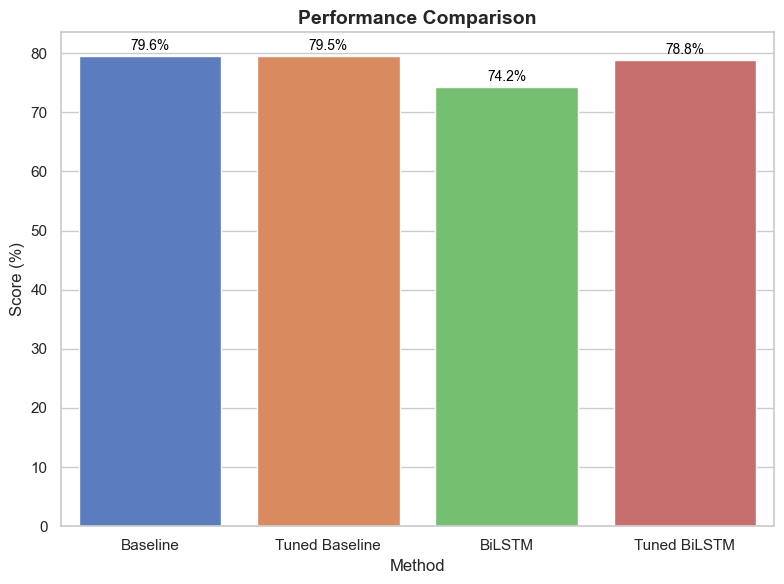

In [199]:
scores = {
    "Baseline": 79.558,
    "Tuned Baseline": 79.466,
    "BiLSTM": 74.226,
    "Tuned BiLSTM": 78.823
}

methods = list(scores.keys())
values = list(scores.values())

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
bars = sns.barplot(x=methods, y=values, hue=methods, legend=False, palette="muted")

for bar, value in zip(bars.patches, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{value:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.title("Performance Comparison", fontsize=14, fontweight="bold")
plt.xlabel("Method", fontsize=12)
plt.ylabel("Score (%)", fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Step 5: Conclusion

After performing my exploratory data analysis (EDA), I wrote a method to clean the data based on what I learned.  I then created 4 models:
1. A baseline model
2. A baseline model with tuned hyperparameters
3. A bi-directional long short-term memory (BiLSTM) model
4. A BiLSTM model with tuned hyperparameters

The baseline model (#1) was computationally inexpensive so that I could iterate on it rapidly.  This baseline model ignored the sequential structure of the text, so it did not meet the requirements of the week 4 class project.  However, it allowed me to experiment with model building, hyperparameter tuning, and to get a baseline score from Kaggle.

Then I created a model that included BiLSTM (bi-directional long short-term memory) to incorporate the sequential structure of the text.  This model was able to incorporate the sequence of the words into the model to improve the accuracy.

Lastly, I performed hyperparameter tuning on the BiLSTM model.  This improved the accuracy by quite a bit (74.226% --> 78.823%), but still did not outperform the original baseline model (79.558%).

In summary, the baseline model using a feed-forward model with TF-IDF performed best.  This suggests that the sequence of words in the tweets was not consequential.

Here are some ideas to further improve this model.
1. Use pretrained embeddings, such as GloVe of FastText.  This leverages word representations that have been trained on large datasets to improve the performance of my model.
2. Try a GRU (gated recurrent units) model instead of BiLSTM.  Both models capture context and dependencies, so I am unsure whether GRU would perform better or worse than BiLSTM.  It would be interesting to test both to see which one is better.
3. Because the number of disaster tweets vs. non-disaster tweets was slightly unbalanced in the training data set, use class weighting (i.e. oversample the minority class or undersample the majority class) when training the model.
4. Add more dense layers to improve learning capacity.
5. Try a transformer model like BERT.